In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Load Titanic Data

In [97]:
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv("titanic_test.csv")
IDtest = test["PassengerId"]
train_len = len(train)
df =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

Data Preprocessing

In [98]:
def determine_age(cols):
    age = cols[0]
    pclass = cols[1]
    if np.isnan(age):
        if(pclass == 1):
            return 37
        elif(pclass==2):
            return 29
        else:
            return 24
    else:
        return age
    
df['Age'] = df[['Age','Pclass']].apply(determine_age,axis=1)

Get Cabin Initials as a new feature

In [99]:
def cabinletter (cabin):
    if pd.isnull(cabin):
        return 'x'
    else:
        return cabin[0]
    
df['CabinInit'] = df['Cabin'].apply(cabinletter)

Get Title and Name length as 2 new feature

In [100]:
df['Title']= df['Name'].apply(lambda name:name.split('.')[0].split(',')[1].strip())

In [101]:
df['NameLength'] = df['Name'].apply(lambda name:len(name.strip()))

In [102]:
#df['Ticket_Lett'] = df['Ticket'].apply(lambda x: str(x)[0])
#df['Ticket_Lett'] = df['Ticket_Lett'].apply(lambda x: str(x))
#df['Ticket_Lett'] = np.where((df['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), df['Ticket_Lett'],
#                                  np.where((df['Ticket_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']),
#                                            'Low_ticket', 'Other_ticket'))

In [103]:
def standardize_title(title):
    if title.lower() in ['mr','miss','mrs','master']:
        return title
    elif title.lower() in ['ms','mlle']:
        return 'Miss'
    elif title.lower() in ['mme']:
        return 'Mrs'
    else:
        return 'Rare'
df['Title'] = df['Title'].apply(standardize_title)

In [104]:
df['FamilySize'] = df[['Parch','SibSp']].apply(lambda cols:cols[0]+cols[1] +1,axis=1)

In [105]:
def normalizefare(cols):
    Ticket = cols[0]
    Fare = cols[1]
    pplinsameticket = len(df[df['Ticket'] == Ticket])   
    if(pplinsameticket > 1):
        Fare = Fare/pplinsameticket
    return Fare

In [106]:
 df['Fare'] = df[['Ticket','Fare']].apply(normalizefare,axis=1)

In [107]:
def FareCategory(Fare):
    if Fare >60:
        return 'High'
    elif Fare <= 60 and Fare >40:
        return 'Medium'
    else:
        return 'Low'

In [108]:
df['FareCategory'] = df['Fare'].apply(FareCategory)

In [109]:
def TravelInGroup(ticket):
    GroupSurvival = 0
    if len(df[df['Ticket'] == ticket]) > 3:
        SurvivedInTicket = len(df[(df['Ticket'] == ticket) & (df['Survived'] == 1)])
        DeadInTicket = len(df[(df['Ticket'] == ticket) & (df['Survived'] == 0)])
        if(SurvivedInTicket+DeadInTicket > 2):
            GroupSurvival = SurvivedInTicket/(SurvivedInTicket + DeadInTicket)
    return GroupSurvival

In [110]:
df['GroupSurvival'] = df['Ticket'].apply(TravelInGroup)

In [111]:
df['Fare'].fillna(0,inplace=True)

In [112]:
df['Embarked'].fillna('S',inplace=True)

In [113]:
df_dummies = pd.get_dummies(df[['Embarked','Title','Sex','CabinInit']],drop_first=True)
df = pd.concat([df,df_dummies], axis=1)
df.drop(labels = ['Embarked','Title','Sex','CabinInit'],axis=1, inplace=True)

In [114]:
df.drop(labels = ['Name','Ticket','Cabin'],axis=1, inplace=True )

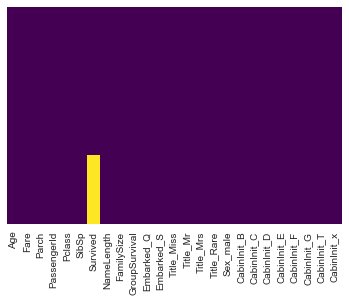

In [115]:
sns.heatmap(df.isnull(),annot=False, yticklabels=False,cbar=False,cmap='viridis')

In [116]:
train = df[:train_len]
test = pd.DataFrame.copy(df[train_len:], deep=True)

In [117]:
test.drop('PassengerId', axis=1, inplace =True)
test.drop('Survived', axis=1, inplace =True)

In [118]:
X = train.drop(labels= ['PassengerId','Survived'],axis=1)
y = train['Survived']

Check for Outlier

In [84]:
# 1st quartile (25%)
Q1 = np.percentile(df['Age'], 25)
# 3rd quartile (75%)
Q3 = np.percentile(df['Age'],75)
# Interquartile range (IQR)
IQR = Q3 - Q1
# outlier step
outlier_step = 1.5 * IQR

# Determine a list of indices of outliers for feature col
outlier_list_col = df[(df['Age'] < Q1 - outlier_step) | (df['Age'] > Q3 + outlier_step )].index

# There are outlier problem in titanic to deal , the above code is for reference

Modelling with common algorithms

In [85]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [86]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import classification,confusion_matrix

Try Stratified K Fold Cross validation 

In [119]:
kfold = StratifiedKFold(n_splits = 10,shuffle=True)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [121]:
lrm = LogisticRegression()
lrm_param_grid = {"C":[.003,.01,.03,1,3,10],
                 }
lrmGS = GridSearchCV(lrm,param_grid = lrm_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
lrmGS.fit(X,y)
lrm_best = lrmGS.best_estimator_

lrmGS.best_score_

#CV_Result = cross_val_score(lrm,X,y, scoring='accuracy',cv=kfold)
#print(CV_Result.mean())
#print(CV_Result.std())

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   28.3s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   28.5s finished


0.82491582491582494

In [122]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3,5],
              "min_samples_split": [3, 10,15],
              "min_samples_leaf": [3, 10,15],
              "bootstrap": [False],
              "n_estimators" :[50,100,200],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X,y)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   46.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 810 out of 810 | elapsed:  5.1min finished


0.84062850729517391

In [142]:
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = RFC_best.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

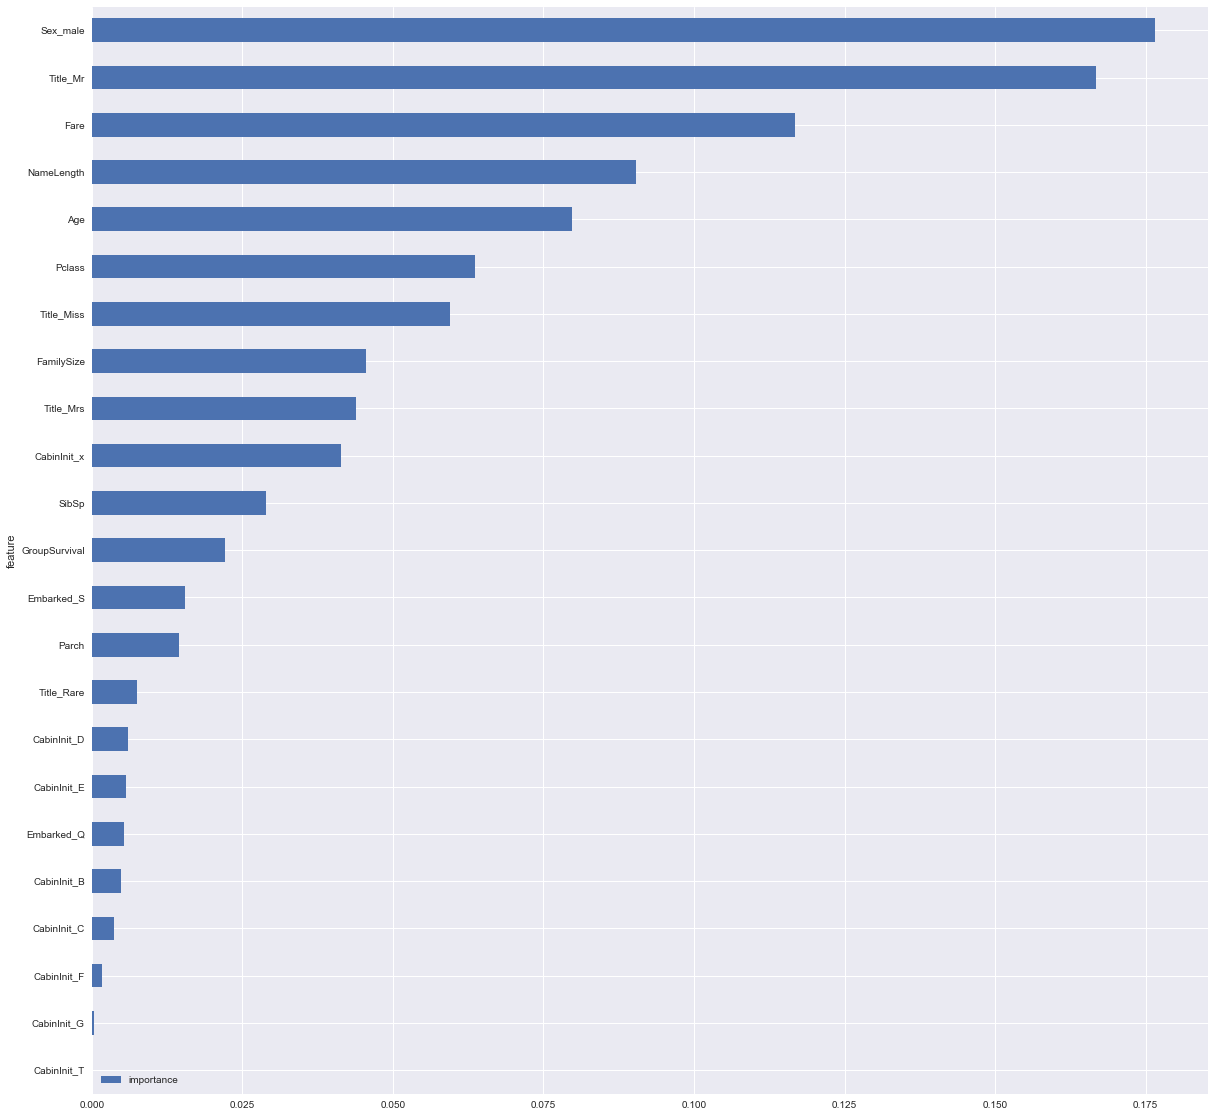

In [143]:
features.plot(kind='barh', figsize=(20, 20))

In [149]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(RFC_best, prefit=True)
train_reduced = model.transform(X)
train_reduced.shape

test_reduced = model.transform(test)
test_reduced.shape
#RFC_best = RandomForestClassifier(n_estimators=100, min_samples_leaf=10,min_samples_split=10,max_features=3, oob_score=True)

(418, 9)

In [150]:
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3,5],
              "min_samples_split": [3, 10,15],
              "min_samples_leaf": [3, 10,15],
              "bootstrap": [False],
              "n_estimators" :[50,100,200],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X,y)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 810 out of 810 | elapsed:  4.2min finished


0.83838383838383834

DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsadaDTC.fit(X,y)
ada_best = gsadaDTC.best_estimator_

gsadaDTC.best_score_

# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X,y)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

In [477]:
#GBC_best = GradientBoostingClassifier(n_estimators=200,learning_rate=0.1,max_depth=4,min_samples_leaf=100,max_features=0.3)

In [151]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [50,100,200,300]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X,y)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   39.6s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:  1.5min finished


0.83501683501683499

In [125]:
SVMC_best

SVC(C=200, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [478]:
#SVMC_best = SVC(probability=True, gamma=0.001,C=1000)

In [479]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#g = plot_learning_curve(gsSVMC.best_estimator_,"SVM learning curves",X,y,cv=kfold)

In [124]:
#g = plot_learning_curve(gsGBC.best_estimator_,"GB learning curves",X,y,cv=kfold)
RFC_best

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Ensembling more than one model

In [152]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('lrm', lrm_best),
('svc', SVMC_best)], voting='soft', n_jobs=4)

#votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('lrm', lrm_best),
#('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X, y)

In [153]:
pred = pd.Series(votingC.predict(test), name='Survived')

In [154]:
output = pd.concat([IDtest,pred.astype(int)], axis=1)

In [155]:
output.to_csv("Titanic_Viswa9.csv",index=False)

In [437]:
df[df['PassengerId'].apply(lambda id: True if id in(893,1231,1236,1251)else False)]

,Age,Parch,PassengerId,Pclass,SibSp,Survived,male,NameLength,Miss,Mr,Mrs,Rare,FamilySize,low,Q,S
892,47.0,0,893,3,1,NaN,0,32,0,0,1,0,2,1,0,1
1230,24.0,0,1231,3,0,NaN,1,21,0,0,0,0,1,1,0,0
1235,24.0,1,1236,3,1,NaN,1,35,0,0,0,0,3,1,0,1
1250,30.0,0,1251,3,1,NaN,0,51,0,0,1,0,2,1,0,1
